# Advanced Learning Rate Schedules

In [16]:
%matplotlib inline
from __future__ import print_function
import copy
import math
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.figure(figsize=(8,6))
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration", fontsize=18)
    plt.ylabel("Learning Rate", fontsize=18)
    plt.show()

# Custom Schedule Shapes

## (Slanted) Triangular

["Cyclical Learning Rates for Training Neural Networks" by Leslie N. Smith (2015)](https://arxiv.org/abs/1506.01186)

["Universal Language Model Fine-tuning for Text Classification" by Jeremy Howard, Sebastian Ruder (2018)](https://arxiv.org/abs/1801.06146)

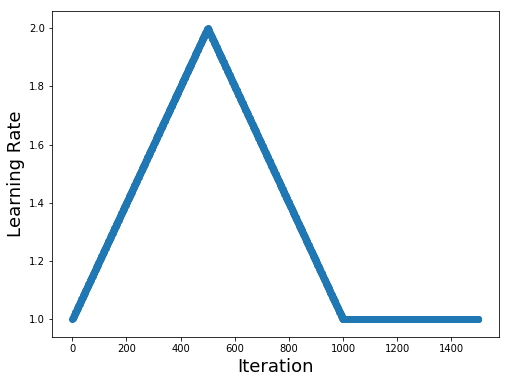

In [33]:
schedule = TriangularSchedule(min_lr=1, max_lr=2, cycle_length=1000, inc_fraction=0.5)
plot_schedule(schedule)

In [31]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        inc_fraction: fraction of iterations spent in increasing stage (float)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

## Cosine

["SGDR: Stochastic Gradient Descent with Warm Restarts" by Ilya Loshchilov, Frank Hutter (2016)](https://arxiv.org/abs/1608.03983)

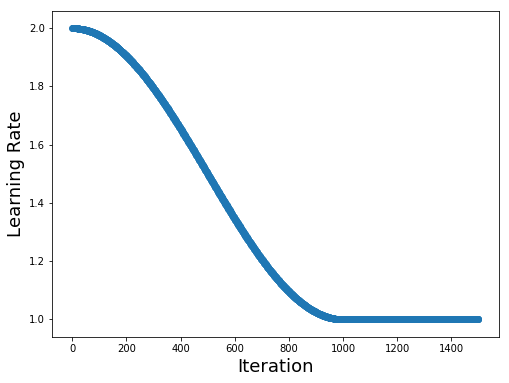

In [20]:
schedule = CosineAnnealingSchedule(min_lr=1, max_lr=2, cycle_length=1000)
plot_schedule(schedule)

In [21]:
class CosineAnnealingSchedule():
    def __init__(self, min_lr, max_lr, cycle_length):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            unit_cycle = (1 + math.cos(iteration * math.pi / self.cycle_length)) / 2
            adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
            return adjusted_cycle
        else:
            return self.min_lr

# Custom Schedule Modifiers

## Warm-Up

["Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour" by Priya Goyal et al. (2017)](https://arxiv.org/abs/1706.02677)

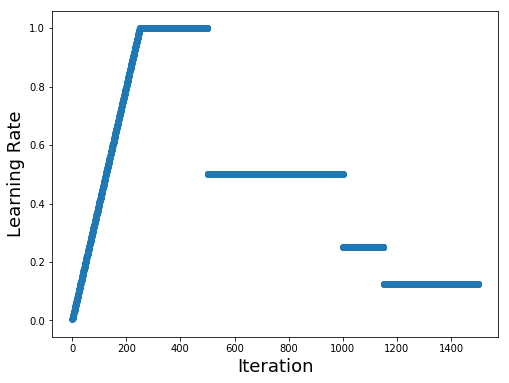

In [22]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
schedule = LinearWarmUp(schedule, start_lr=0, length=250)
plot_schedule(schedule)

In [23]:
class LinearWarmUp():
    def __init__(self, schedule, start_lr, length):
        """
        schedule: a pre-initialized schedule (e.g. TriangularSchedule(min_lr=0.5, max_lr=2, cycle_length=500))
        start_lr: learning rate used at start of the warm-up (float)
        length: number of iterations used for the warm-up (int)
        """
        self.schedule = schedule
        self.start_lr = start_lr
        # calling mx.lr_scheduler.LRScheduler effects state, so calling a copy
        self.finish_lr = copy.copy(schedule)(0)
        self.length = length
    
    def __call__(self, iteration):
        if iteration <= self.length:
            return iteration * (self.finish_lr - self.start_lr)/(self.length) + self.start_lr
        else:
            return self.schedule(iteration - self.length)

## Cool-Down

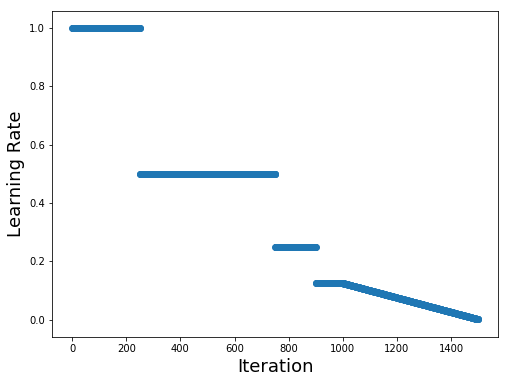

In [24]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
schedule = LinearCoolDown(schedule, finish_lr=0.001, start_idx=1000, length=500)
plot_schedule(schedule)

In [25]:
class LinearCoolDown():
    def __init__(self, schedule, finish_lr, start_idx, length):
        """
        schedule: a pre-initialized schedule (e.g. TriangularSchedule(min_lr=0.5, max_lr=2, cycle_length=500))
        finish_lr: learning rate used at end of the cool-down (float)
        start_idx: iteration to start the cool-down (int)
        length: number of iterations used for the cool-down (int)
        """
        self.schedule = schedule
        # calling mx.lr_scheduler.LRScheduler effects state, so calling a copy
        self.start_lr = copy.copy(self.schedule)(start_idx)
        self.finish_lr = finish_lr
        self.start_idx = start_idx
        self.finish_idx = start_idx + length
        self.length = length
    
    def __call__(self, iteration):
        if iteration <= self.start_idx:
            return self.schedule(iteration)
        elif iteration <= self.finish_idx:
            return (iteration - self.start_idx) * (self.finish_lr - self.start_lr) / (self.length) + self.start_lr
        else:
            return self.finish_lr

### 1-Cycle: for "Super-Convergence"

["Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates" by Leslie N. Smith, Nicholay Topin (2017)](https://arxiv.org/abs/1708.07120)

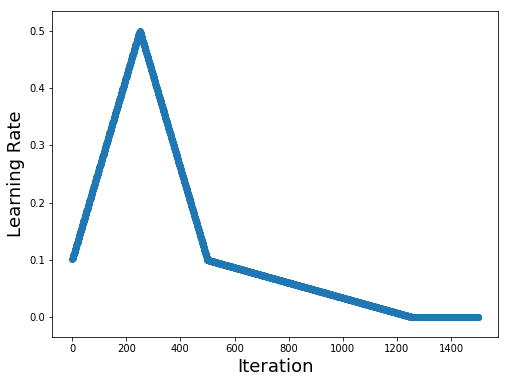

In [26]:
schedule = OneCycleSchedule(start_lr=0.1, max_lr=0.5, cycle_length=500, cooldown_length=750, finish_lr=0.001)
plot_schedule(schedule)

In [27]:
class OneCycleSchedule():
    def __init__(self, start_lr, max_lr, cycle_length, cooldown_length=0, finish_lr=None):
        """
        start_lr: lower bound for learning rate in triangular cycle (float)
        max_lr: upper bound for learning rate in triangular cycle (float)
        cycle_length: iterations between start and finish of triangular cycle: 2x 'stepsize' (int)
        cooldown_length: number of iterations used for the cool-down (int)
        finish_lr: learning rate used at end of the cool-down (float)
        """
        if (cooldown_length > 0) and (finish_lr is None):
            raise ValueError("Must specify finish_lr when using cooldown_length > 0.")
        if (cooldown_length == 0) and (finish_lr is not None):
            raise ValueError("Must specify cooldown_length > 0 when using finish_lr.")
            
        finish_lr = finish_lr if (cooldown_length > 0) else start_lr
        schedule = TriangularSchedule(min_lr=start_lr, max_lr=max_lr, cycle_length=cycle_length)
        self.schedule = LinearCoolDown(schedule, finish_lr=finish_lr, start_idx=cycle_length, length=cooldown_length)
        
    def __call__(self, iteration):
        return self.schedule(iteration)

## Cyclical

["Cyclical Learning Rates for Training Neural Networks" by Leslie N. Smith (2015)](https://arxiv.org/abs/1506.01186)

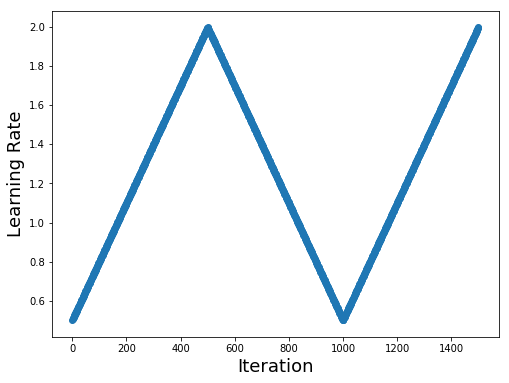

In [36]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=1000)
plot_schedule(schedule)   

In [29]:
class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        """
        schedule_class: class of schedule, expected to take `cycle_length` argument
        cycle_length: iterations used for initial cycle (int)
        cycle_length_decay: factor multiplied to cycle_length each cycle (float)
        cycle_magnitude_decay: factor multiplied learning rate magnitudes each cycle (float)
        kwargs: passed to the schedule_class
        """
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx  

["SGDR: Stochastic Gradient Descent with Warm Restarts" by Ilya Loshchilov, Frank Hutter (2016)](https://arxiv.org/abs/1608.03983)

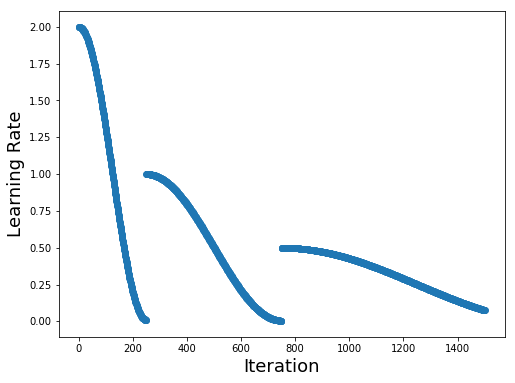

In [30]:
schedule = CyclicalSchedule(CosineAnnealingSchedule, min_lr=0.01, max_lr=2,
                            cycle_length=250, cycle_length_decay=2, cycle_magnitude_decay=0.5)
plot_schedule(schedule)